In [80]:
#IMPORT Libraries
import pandas as pd
import numpy as np
import math
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from IPython.display import display

In [81]:
# create a dataframe for the pipe data. This is done bases on my local files, but need to aligned to the final result of the Feature Engineering and Data Cleaning
#point to the folder where the data is stored for Diana
os.chdir(r"C:\Users\dianaf\OneDrive\IE\Datathon") 

df_network = pd.read_csv("df_submission1.csv") #909733 rows - test data set

df_inspection = pd.read_csv("inspections.csv") #6345344 rows - inspection data set

df = pd.merge(df_inspection, df_network, on="PipeId")

In [82]:
#define the sample size we run through for the comparison. Need to find a way to do it thru all the data set

df_cost = df


In [83]:
df_cost.shape

(3976947, 18)

# BASELINE COST CALCULATION

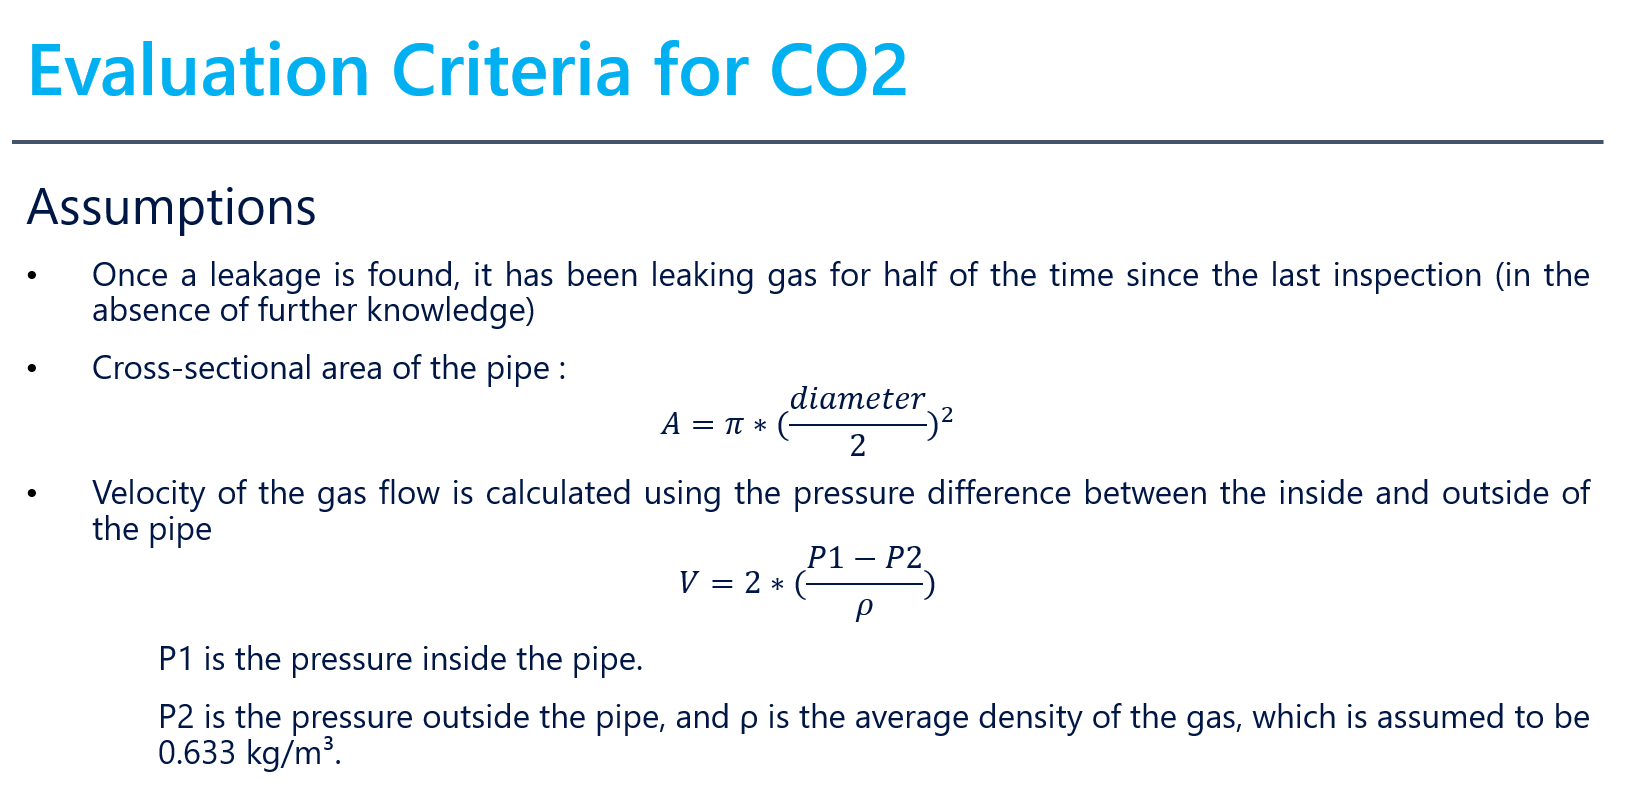

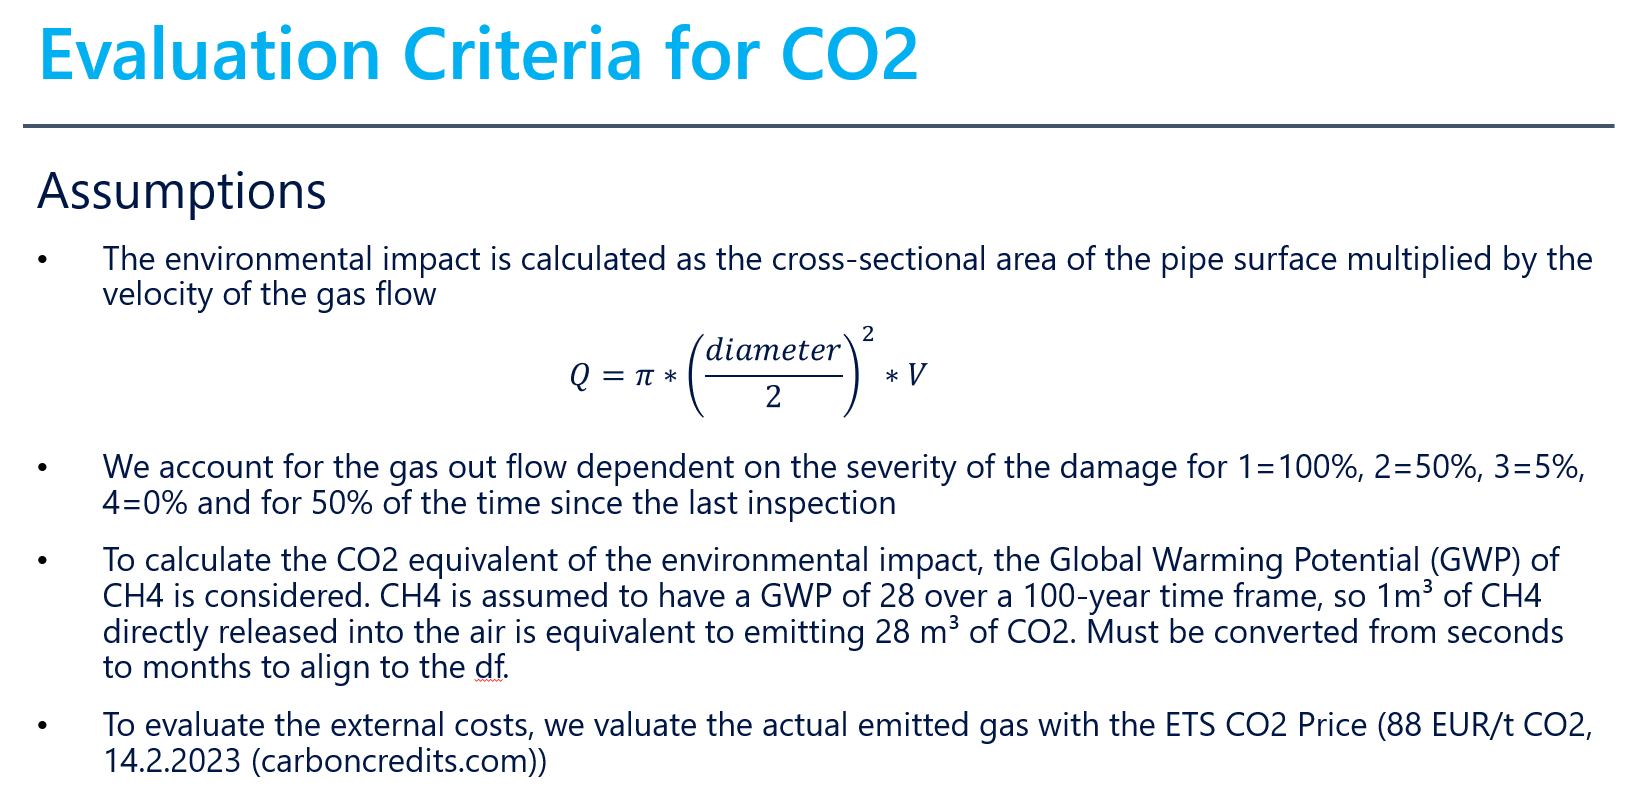

In [84]:
# Formula for Environmental Impact 


df_cost['b_Co2'] = np.where(df_cost['Severity'] == 1, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*1*88,
                            np.where(df_cost['Severity'] == 2, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0.5*88,
                            np.where(df_cost['Severity'] == 3, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0.05*88,
                            np.where(df_cost['Severity'] == 4, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633* df_cost['MonthsLastRev']*0.5*2629800*28*0*88, np.nan))))
df.head()


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,b_Co2
0,188889914,ZRV-00001406,2010,2010-10-01,22,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.0
1,188889914,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.0
2,188889914,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.0
3,188889914,ZRV-00001406,2015,2015-11-06,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.0
4,188889914,ZRV-00001406,2017,2017-11-25,24,4,0,Barcelona,Barcelona,1999,PE,Gas natural,160.0,1.292,0.025,0,0,False,0.0


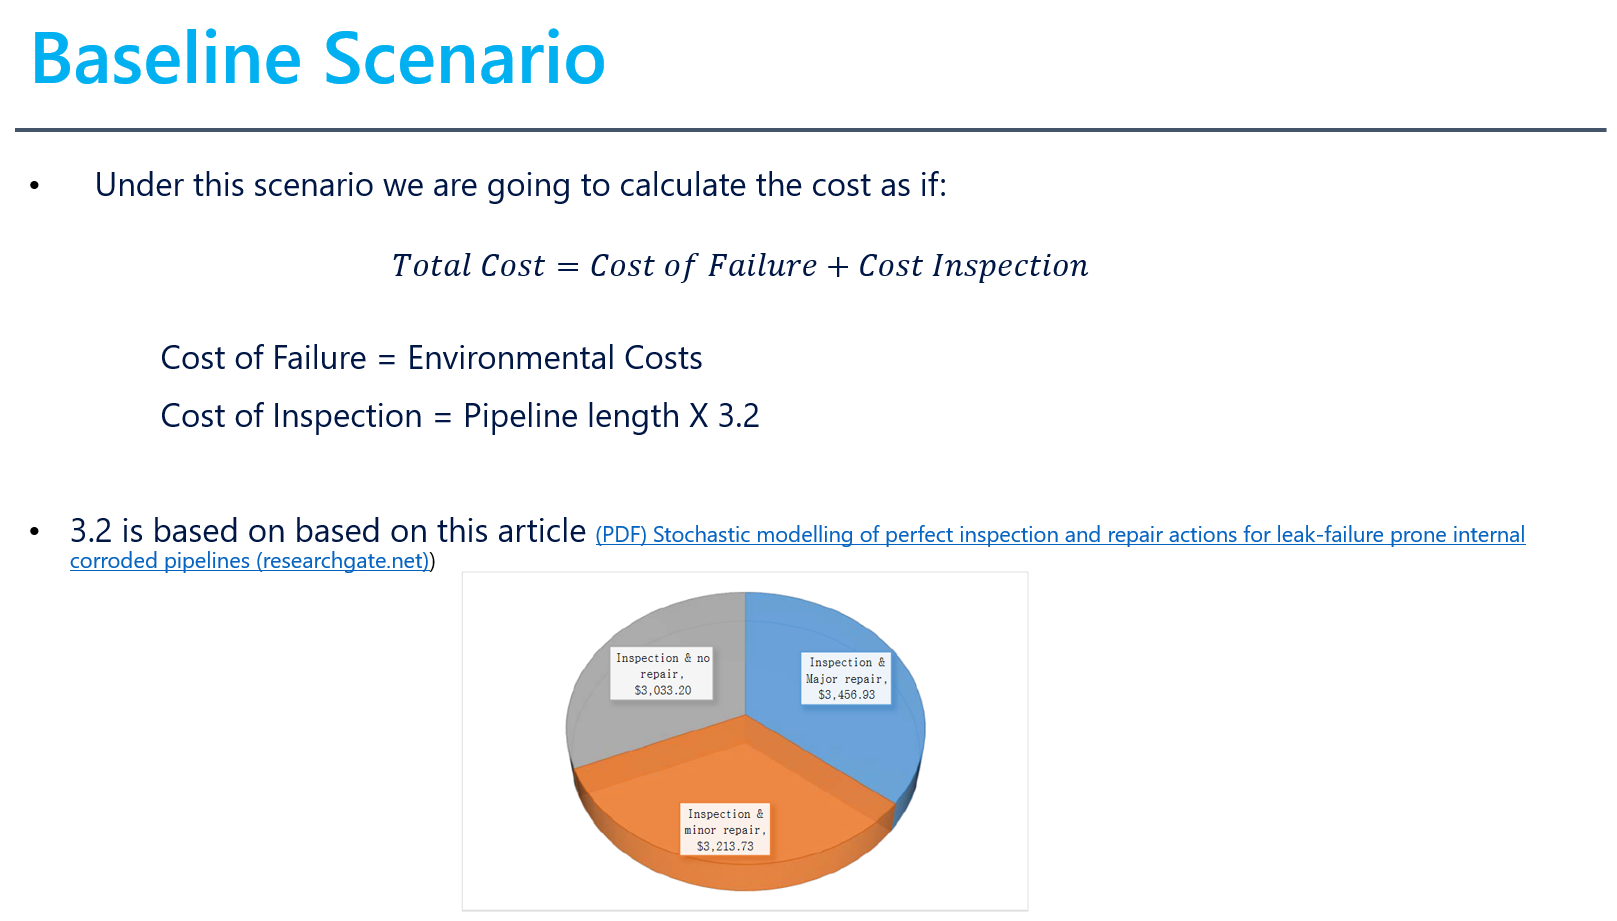

In [85]:
# sum costs for baseline scenario
results = pd.DataFrame()

# failure costs
results['b_failure_costs'] = df_cost.groupby("InspectionYear").sum()["b_Co2"]

# inspection costs // per length
df_cost['b_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['b_insp_costs'] = df_cost.groupby("InspectionYear").sum()["b_insp_costs"]

# total costs
results['b_total_costs'] = results['b_failure_costs'] + results['b_insp_costs']

results


,b_failure_costs,b_insp_costs,b_total_costs
InspectionYear,,,
2010,2.073233e+04,4.003455e+06,4.024187e+06
2011,6.408382e+06,4.820027e+07,5.460865e+07
2012,6.837245e+06,3.364661e+07,4.048385e+07
2013,8.723400e+06,5.859105e+07,6.731445e+07
2014,3.727195e+06,2.945857e+07,3.318577e+07
2015,1.618901e+07,6.299152e+07,7.918053e+07
2016,5.121825e+06,2.968867e+07,3.481049e+07
2017,4.402514e+06,7.609450e+07,8.049702e+07
2018,3.514387e+06,2.952042e+07,3.303480e+07


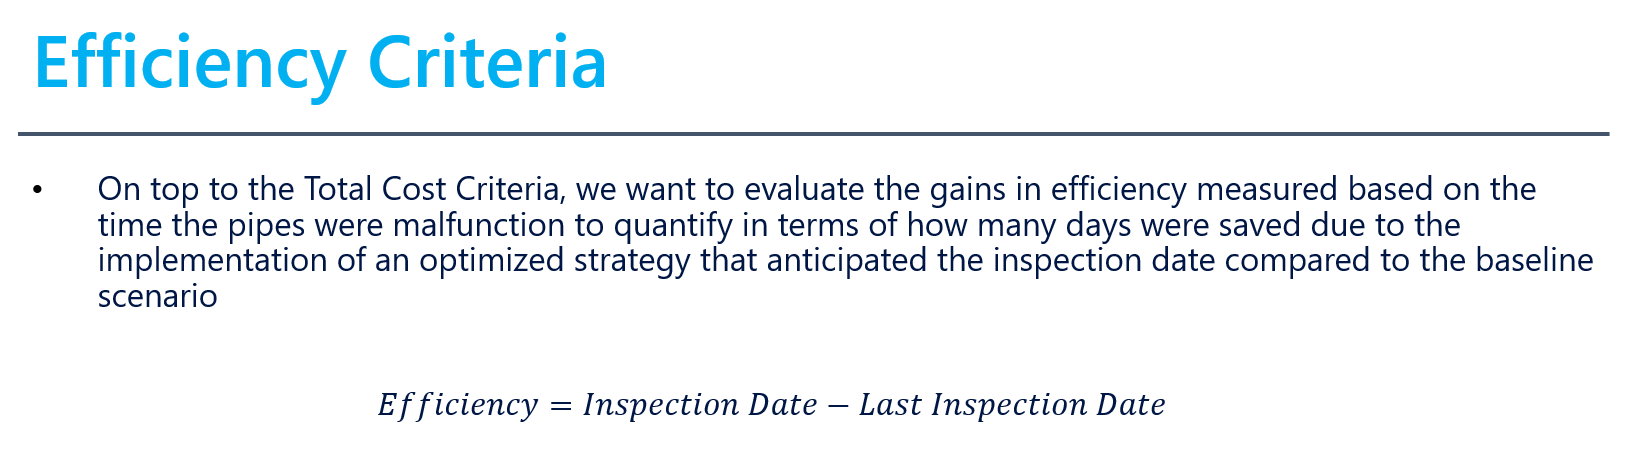

In [86]:
#efficiency measure is a proxy of the time between failure and detection, based on data available we will expressed as sum of days
#between the inspection date and the last inspection date

df_cost['InspectionDate'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')
df_cost['LastInspect'] = df_cost['InspectionDate'] - pd.TimedeltaIndex(df_cost['MonthsLastRev'], unit='h')
df_cost['b_timedifference']=(df_cost['InspectionDate']-df_cost['LastInspect']).dt.total_seconds()/(24*60*60*30) 

results['b_timedifference'] = df_cost.groupby("InspectionYear").sum()["b_timedifference"]

# Parameter Set for Optimized Scenarios 

In [87]:
# For now, randomly assigning class variable 1 or 0 and probability of failure. It needs to be replaced by the probabilty out of the ML model
mean = 0.5
std = 0.1

df_cost['random_variable'] = np.random.normal(mean, std, df_cost.shape[0])

df_cost.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,b_Co2,b_insp_costs,LastInspect,b_timedifference,random_variable
0,188889914,ZRV-00001406,2010,2010-10-01,22,4,0,Barcelona,Barcelona,1999,...,1.292,0.025,0,0,False,0.0,4.1344,2010-09-30 02:00:00,0.030556,0.358287
1,188889914,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,...,1.292,0.025,0,0,False,0.0,4.1344,2011-11-16 11:00:00,0.018056,0.423159
2,188889914,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,...,1.292,0.025,0,0,False,0.0,4.1344,2013-11-11 00:00:00,0.033333,0.314048
3,188889914,ZRV-00001406,2015,2015-11-06,24,4,0,Barcelona,Barcelona,1999,...,1.292,0.025,0,0,False,0.0,4.1344,2015-11-05 00:00:00,0.033333,0.584255
4,188889914,ZRV-00001406,2017,2017-11-25,24,4,0,Barcelona,Barcelona,1999,...,1.292,0.025,0,0,False,0.0,4.1344,2017-11-24 00:00:00,0.033333,0.457722


In [88]:
# The idea of this optimization scenario is to run it week by week from start_date to end_date and selects those pipes with the highest probability of failure 

# 1st: we have to define parameters for the discrete optimization model for scenario centralized and decentralized

start_date_str = "2010-01-01"
end_date_str = "2020-12-31"

start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

# 2nd: set the number of inspected pipes per week for each iteration, it can be adjust/changed based on our EDA

num_selected = 20


#3rd: we evaluate every inspection based on CO2 costs which evolve due to leaking gas. df['fco2'] is the factor we multiply with the time of leakage


df_cost['fco2'] = np.where(df_cost['Severity'] == 1, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*1*88,
                            np.where(df_cost['Severity'] == 2, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.5*88,
                            np.where(df_cost['Severity'] == 3, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0.05*88,
                            np.where(df_cost['Severity'] == 4, (df_cost['Diameter']/2/1000)**2 * np.pi * df_cost['Pressure'] * 2 / 100000 / 0.633*0.5*2629800*28*0*88, np.nan))))



# reformate inspection date and lastInspect for datetime 
df_cost['InspectionDate'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')
df_cost['LastInspect'] = df_cost['InspectionDate'] - pd.TimedeltaIndex(df_cost['MonthsLastRev']*4, unit='W')



In [89]:
df_cost['fco2'].head(80)


0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
75    2.572762
76    0.000000
77    0.000000
78    0.000000
79    0.000000
Name: fco2, Length: 80, dtype: float64

# Decentralized Scenario


In [90]:
#calculation of the costs for failure, with a focus on the environmental costs for CO2

#d...    d scenario
#CO2...  costs for failure with a focus on CO2
#base... costs for inspection per km pipe

In [91]:
# Create Dataframes for decentralized optimization

df_cost['d_random_variable']=df_cost['random_variable'] # d_random variable is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function

df_cost['d_InspectionDate_op'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')


df_cost['LastInspect'] = df_cost['InspectionDate'] - pd.TimedeltaIndex(df_cost['MonthsLastRev'], unit='h')
df_cost['d_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took

#formatting all dates for datetime

#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df_cost['d_failure_costs'] = 0 




In [92]:
timedelta= end_date-start_date
timedelta


datetime.timedelta(days=4017)

In [93]:
# Run through the optimization for the decentralized approach


pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
     # STEP 1: Take the highest 250 values of df['d_random_variable']
     # select the top num_selected rows based on prediction input =(random variable)

        df_sorted = df_cost.sort_values('d_random_variable', ascending=False).iloc[:num_selected]
    
    # STEP2: Add inspection date

        df_cost.loc[df_sorted.index, 'd_InspectionDate_op'] = date
       # df.loc[df_sorted.index, 'd_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].copy() 
        


    # STEP 3: Failure and Cost Valuation
    
        df_sorted['d_timedifference'] =  (df_sorted['d_InspectionDate_op']-df_sorted['LastInspect']).dt.total_seconds()/(24*60*60*30) 
        df_sorted['d_timedifference'] =  np.maximum(df_sorted['d_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
        df_cost.loc[df_sorted.index, 'd_timedifference'] = df_sorted['d_timedifference'].copy() 
       
    
        df_sorted['d_failure_costs'] =  df_sorted['d_timedifference'] *df_sorted['fco2']
        df_cost.loc[df_sorted.index, 'd_failure_costs'] = df_sorted['d_failure_costs'].copy() 
        
        
        df_sorted['d_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].dt.strftime('%Y-%m-%d')
        
        df_cost.loc[df_sorted.index, 'd_InspectionDate_op'] = df_sorted['d_InspectionDate_op'].values
        
        
   # STEP 4: Set back df['d_random_variable']

# 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
        
        df_sorted['d_random_variable'] =  df_sorted['d_random_variable']*0.5 
        df_cost.loc[df_sorted.index, 'd_random_variable'] = df_sorted['d_random_variable'].copy()

        
        # Update the progress bar

        pbar.update() # assuming we're iterating through weeks
        
       



574it [05:44,  1.67it/s]00:00<?, ?it/s]
 30%|███       | 172/573 [16:41<36:54,  5.52s/it]  

In [ ]:
df_cost['InspectionDate']

73      2011-11-17
74      2013-11-12
75      2015-11-06
76      2017-11-23
77      2019-11-21
           ...    
10068   2016-03-30
10069   2017-04-06
10070   2018-02-21
10071   2019-12-11
10072   2020-12-14
Name: InspectionDate, Length: 10000, dtype: datetime64[ns]

In [ ]:
df_cost['d_InspectionDate_op']

73      2011-11-17
74      2013-11-12
75      2015-11-06
76      2017-11-23
77      2019-11-21
           ...    
10068   2016-03-30
10069   2017-04-06
10070   2018-02-21
10071   2019-12-11
10072   2020-12-14
Name: d_InspectionDate_op, Length: 10000, dtype: datetime64[ns]

In [ ]:
df_cost.to_csv('my_data.csv', index=False)


In [ ]:
#writing an inspection year for scenario decentralized
df_cost['d_inspection_year'] = df_cost['d_InspectionDate_op'].dt.year
df_cost

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,b_insp_costs,LastInspect,b_timedifference,random_variable,fco2,d_random_variable,d_InspectionDate_op,d_timedifference,d_failure_costs,d_inspection_year
73,188889938,ZRV-00001406,2011,2011-11-17,13,4,0,Barcelona,Barcelona,1999,...,246.4768,2011-11-16 11:00:00,0.018056,0.599584,0.000000,0.149896,2011-11-17,0.018056,0.000000,2011
74,188889938,ZRV-00001406,2013,2013-11-12,24,4,0,Barcelona,Barcelona,1999,...,246.4768,2013-11-11 00:00:00,0.033333,0.512946,0.000000,0.256473,2013-11-12,0.033333,0.000000,2013
75,188889938,ZRV-00001406,2015,2015-11-06,24,3,1,Barcelona,Barcelona,1999,...,246.4768,2015-11-05 00:00:00,0.033333,0.432717,2.572762,0.216359,2015-11-06,0.033333,0.085759,2015
76,188889938,ZRV-00001406,2017,2017-11-23,24,4,0,Barcelona,Barcelona,1999,...,246.4768,2017-11-22 00:00:00,0.033333,0.681239,0.000000,0.170310,2017-11-23,0.033333,0.000000,2017
77,188889938,ZRV-00001406,2019,2019-11-21,24,4,0,Barcelona,Barcelona,1999,...,246.4768,2019-11-20 00:00:00,0.033333,0.725073,0.000000,0.181268,2019-11-21,0.033333,0.000000,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,20670797,ZRV-00003733,2016,2016-03-30,9,4,0,Madrid,Madrid,1997,...,131.6416,2016-03-29 15:00:00,0.012500,0.536962,0.000000,0.268481,2016-03-30,0.0125,0.000000,2016
10069,20670797,ZRV-00003734,2017,2017-04-06,13,4,0,Madrid,Madrid,1997,...,131.6416,2017-04-05 11:00:00,0.018056,0.384566,0.000000,0.192283,2017-04-06,0.018056,0.000000,2017
10070,20670797,ZRV-00003733,2018,2018-02-21,10,4,0,Madrid,Madrid,1997,...,131.6416,2018-02-20 14:00:00,0.013889,0.474864,0.000000,0.237432,2018-02-21,0.013889,0.000000,2018
10071,20670797,ZRV-00003733,2019,2019-12-11,22,4,0,Madrid,Madrid,1997,...,131.6416,2019-12-10 02:00:00,0.030556,0.399289,0.000000,0.199644,2019-12-11,0.030556,0.000000,2019


In [ ]:
df_sorted.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,...,b_Co2,b_insp_costs,LastInspect,b_timedifference,random_variable,fco2,d_random_variable,d_InspectionDate_op,d_timedifference,d_failure_costs
7549,307828736,ZRV-00004432,2013,2013-03-12,6,4,0,Valencia,Pobla de Vallbona,2008,...,0.0,4.1696,2013-03-11 18:00:00,0.008333,0.597013,0.0,0.149253,2013-03-12,0.008333,0.0
1228,13080255,ZRV-00003733,2014,2014-06-23,23,4,0,Madrid,Madrid,1994,...,0.0,6.6016,2014-06-22 01:00:00,0.031944,0.597011,0.0,0.149253,2014-06-23,0.031944,0.0
8918,189103489,ZRV-00003573,2015,2015-11-12,24,4,0,Tarragona,Calafell,2000,...,0.0,15.6736,2015-11-11 00:00:00,0.033333,0.596911,0.0,0.149228,2015-11-12,0.033333,0.0
7609,312586529,ZRV-00004432,2013,2013-03-09,7,4,0,Valencia,Pobla de Vallbona,2006,...,0.0,180.1728,2013-03-08 17:00:00,0.009722,0.596800,0.0,0.149200,2013-03-09,0.009722,0.0
6241,24619260,ZRV-00003733,2016,2016-04-07,22,4,0,Madrid,Madrid,1996,...,0.0,56.7744,2016-04-06 02:00:00,0.030556,0.596773,0.0,0.149193,2016-04-07,0.030556,0.0


In [ ]:
df_cost['d_timedifference']


73       0.018056
74       0.033333
75       0.033333
76       0.033333
77       0.033333
           ...   
10068      0.0125
10069    0.018056
10070    0.013889
10071    0.030556
10072    0.016667
Name: d_timedifference, Length: 10000, dtype: object

In [ ]:
# sum costs for decentralized scenario

#duration of malfunctioning

df_cost['d_timedifference'] = df_cost['d_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['d_timedifference'] = df_cost.groupby("d_inspection_year").sum()["d_timedifference"]


# failure costs
results['d_failure_costs'] = df_cost.groupby("d_inspection_year").sum()["d_failure_costs"]

# inspection costs // per length
df_cost['d_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13

results['d_insp_costs'] = df_cost.groupby("d_inspection_year").sum()["d_insp_costs"]

# total costs
results['d_total_costs'] = results['d_failure_costs'] + results['d_insp_costs']

results

,b_failure_costs,b_insp_costs,b_total_costs,b_timedifference,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs
InspectionYear,,,,,,,,
2010,14165.119809,189496.2560,203661.375809,50.176389,87.022222,17.723704,189496.2560,189513.979704
2011,714.122289,30591.7440,31305.866289,5.019444,12.875000,0.991837,30591.7440,30592.735837
2012,34626.605011,162155.5264,196782.131411,41.027778,64.331944,48.092507,162155.5264,162203.618907
2013,0.000000,67574.3296,67574.329600,14.404167,29.136111,0.000000,67574.3296,67574.329600
2014,9315.198551,125891.2608,135206.459351,33.716667,55.033333,12.937776,125891.2608,125904.198576
2015,796.189370,67272.8064,68068.995770,19.981944,34.430556,1.105819,67272.8064,67273.912219
2016,6966.200000,126107.7440,133073.944000,32.297222,50.709722,9.675278,126107.7440,126117.419278
2017,0.000000,67798.7712,67798.771200,19.911111,34.423611,0.000000,67798.7712,67798.771200
2018,6924.347115,125976.4384,132900.785515,33.276389,54.586111,9.617149,125976.4384,125986.055549


# Centralized Scenario

In [ ]:
# this is a restricted scenario, where the maintenance teams can only inspect pipes in one specific area of spain. 
# For that purpose we create a probability score indicator for the region to send out the maintenance team each week with highest score
# The teams are deployed in one region at a time and get´s redeployed to another region the next week 

In [ ]:
# Create Dataframes for Cecentralized optimization

df_cost['c_random_variable']=df_cost['random_variable'] # d_random varialbe is the random variable which changes through out the simulation. 

#prepare time indicators for evaluating the failure function

df_cost['c_InspectionDate_op'] = pd.to_datetime(df_cost['InspectionDate'], format='%Y-%m-%d')


df_cost['LastInspect'] = df_cost['InspectionDate'] - pd.TimedeltaIndex(df_cost['MonthsLastRev']*4, unit='h')
df_cost['c_timedifference'] = pd.to_timedelta(1, unit='D') #this variable evaluates how long the mal supply took


#Create variable for the costs for mal supply and emitting CO2 into the atomosphere // external costs
df_cost['c_failure_costs'] = 0 

In [ ]:
#build a probility score for each region where the maintenance teams can operate within one timeperiode. 

prob_score=df_cost.groupby("Province").sum()["random_variable"]
df_cost['Prob_score']=1
df_cost['Prob_score'] = df_cost['Province'].map(prob_score)


In [ ]:

# Run through the optimization for the centralized approach

#build a probility score for each region where the maintenance teams can operate within one timeperiode. 


df_cost['Prob_score']=1   

#create a bar plot for the runntime
pbar = tqdm(total=(end_date - start_date).days // 7)

# STEP 0: Create a loop structure to go through week by week
for date in pd.date_range(start_date, end_date, freq='W'):
    
 # STEP 1: Create the regional probability score table
    

        prob_score=df_cost.groupby("Province").sum()["c_random_variable"]
        
        df_cost['Prob_score'] = df_cost['Province'].map(prob_score)
        
        df_sorted = df_cost.sort_values('Prob_score', ascending=False).iloc[:num_selected]

        
        
  # STEP2: Add inspection date

        df_cost.loc[df_sorted.index, 'c_InspectionDate_op'] = date
        df_cost.loc[df_sorted.index, 'c_InspectionDate_op'] = df_sorted['c_InspectionDate_op'].copy() 


  # STEP 3: Failure and Cost Valuation
    
        df_sorted['c_timedifference'] =  (df_sorted['c_InspectionDate_op']-df_sorted['LastInspect']).dt.total_seconds()/(24*60*60*30) 
        df_sorted['c_timedifference'] =  np.maximum(df_sorted['c_timedifference'], 0) #the max function insures, that if the last inspection in the data took place after the optimized inspection, that it is 0 and nonnegative
        df_cost.loc[df_sorted.index, 'c_timedifference'] = df_sorted['c_timedifference'].copy() 
       
    
        df_sorted['c_failure_costs'] =  df_sorted['c_timedifference'] *df_sorted['fco2']
        df_cost.loc[df_sorted.index, 'c_failure_costs'] = df_sorted['c_failure_costs'].copy() 
        
        
   # STEP 4: Set back df['c_random_variable']

        df_sorted['c_random_variable'] =  df_sorted['c_random_variable']*0.5 # 0.5  is an assumption that the risk for another failure is set off by 50% after inspection and repair
        df_cost.loc[df_sorted.index, 'c_random_variable'] = df_sorted['c_random_variable'].copy()
         

        
        # Update the progress bar

        pbar.update()       
        
  
        
        
     

574it [00:07, 75.60it/s]                          


In [ ]:
#writing an inspection year for scenario centralized
df_cost['c_inspection_year'] = df_cost['c_InspectionDate_op'].dt.year
df_cost.head()
df_cost.to_csv('my_data.csv', index=False)


In [ ]:
# sum costs for centralized scenario

#duration of malfunctioning

df_cost['c_timedifference'] = df_cost['c_timedifference'].apply(lambda x: int(x.days) if isinstance(x, pd.Timedelta) else x)
results['c_timedifference'] = df_cost.groupby("c_inspection_year").sum()["c_timedifference"]
# failure costs
results['c_failure_costs'] = df_cost.groupby("c_inspection_year").sum()["c_failure_costs"]

# inspection costs // per length
df_cost['c_insp_costs'] = df_cost['Length']*3.2 # based on https://www.researchgate.net/publication/284228211_Stochastic_modelling_of_perfect_inspection_and_repair_actions_for_leak-failure_prone_internal_corroded_pipelines#pf13
results['c_insp_costs'] = df_cost.groupby("c_inspection_year").sum()["c_insp_costs"]

# total costs
results['c_total_costs'] = results['c_failure_costs'] + results['c_insp_costs']

results



,b_failure_costs,b_insp_costs,b_total_costs,b_timedifference,d_timedifference,d_failure_costs,d_insp_costs,d_total_costs,c_timedifference,c_failure_costs,c_insp_costs,c_total_costs
InspectionYear,,,,,,,,,,,,
2010,14165.119809,189496.2560,203661.375809,50.176389,87.022222,17.723704,189496.2560,189513.979704,1659.366667,0,189496.2560,189496.2560
2011,714.122289,30591.7440,31305.866289,5.019444,12.875000,0.991837,30591.7440,30592.735837,284.000000,0,30591.7440,30591.7440
2012,34626.605011,162155.5264,196782.131411,41.027778,64.331944,48.092507,162155.5264,162203.618907,1379.366667,0,162155.5264,162155.5264
2013,0.000000,67574.3296,67574.329600,14.404167,29.136111,0.000000,67574.3296,67574.329600,601.000000,0,67574.3296,67574.3296
2014,9315.198551,125891.2608,135206.459351,33.716667,55.033333,12.937776,125891.2608,125904.198576,1069.494444,0,125891.2608,125891.2608
2015,796.189370,67272.8064,68068.995770,19.981944,34.430556,1.105819,67272.8064,67273.912219,604.000000,0,67272.8064,67272.8064
2016,6966.200000,126107.7440,133073.944000,32.297222,50.709722,9.675278,126107.7440,126117.419278,1056.350000,0,126107.7440,126107.7440
2017,0.000000,67798.7712,67798.771200,19.911111,34.423611,0.000000,67798.7712,67798.771200,607.000000,0,67798.7712,67798.7712
2018,6924.347115,125976.4384,132900.785515,33.276389,54.586111,9.617149,125976.4384,125986.055549,1055.511111,0,125976.4384,125976.4384


In [ ]:
total_cost_comparision = pd.DataFrame()

total_cost_comparision['b_total_costs'] = results['b_total_costs']
total_cost_comparision['c_total_costs'] = results['c_total_costs']
total_cost_comparision['d_total_costs'] = results['d_total_costs']

total_cost_comparision

,b_total_costs,c_total_costs,d_total_costs
InspectionYear,,,
2010,203661.375809,189496.2560,189513.979704
2011,31305.866289,30591.7440,30592.735837
2012,196782.131411,162155.5264,162203.618907
2013,67574.329600,67574.3296,67574.329600
2014,135206.459351,125891.2608,125904.198576
2015,68068.995770,67272.8064,67273.912219
2016,133073.944000,126107.7440,126117.419278
2017,67798.771200,67798.7712,67798.771200
2018,132900.785515,125976.4384,125986.055549


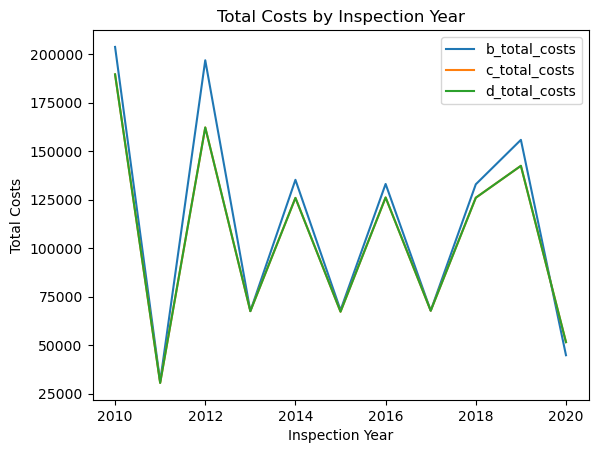

In [ ]:
import matplotlib.pyplot as plt

# create the dataframe from the table
data = {'b_total_costs': total_cost_comparision['b_total_costs'],
        'c_total_costs': total_cost_comparision['c_total_costs'],
        'd_total_costs': total_cost_comparision['d_total_costs']}
df_p = pd.DataFrame(data, index=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

# create the figure and axis objects
fig, ax = plt.subplots()

# plot the lines
df_p.plot(ax=ax)

# set the title and axis labels
ax.set_title('Total Costs by Inspection Year')
ax.set_xlabel('Inspection Year')
ax.set_ylabel('Total Costs')

# show the plot
plt.show()



In [ ]:
efficiency_comparision = pd.DataFrame()

efficiency_comparision['b_timedifference'] = results['b_timedifference']
efficiency_comparision['c_timedifference'] = results['c_timedifference']
efficiency_comparision['d_timedifference'] = results['d_timedifference']

efficiency_comparision

,b_timedifference,c_timedifference,d_timedifference
InspectionYear,,,
2010,50.176389,1659.366667,87.022222
2011,5.019444,284.000000,12.875000
2012,41.027778,1379.366667,64.331944
2013,14.404167,601.000000,29.136111
2014,33.716667,1069.494444,55.033333
2015,19.981944,604.000000,34.430556
2016,32.297222,1056.350000,50.709722
2017,19.911111,607.000000,34.423611
2018,33.276389,1055.511111,54.586111
